#### Final Project Davide Modolo
## Is AI suitable for forecasting Stock prices?
This is the code I implemented for the **AI for Finance** course final project.
The idea is to predict the average price of the following day starting from open, close, high, low, volume, count, sentiment_value of a day

### Libraries
A part from the usual python libraries, for this project there are 3 main types of libs we need to use:
- Eikon Libraries to exchange information with the Refinitiv database
- Statsmodel API to use OLS as the required econometric method
- Neural Network libs, divided in Natural Language in order to perform a Sentiment Analysis on news headlines and Neural Network in order to build our NN for forecasting price

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor, ceil
from IPython.display import clear_output #to write download progress in console
from os.path import exists


# Importing Eikon libraries for stock data
import eikon as ek
import cufflinks as cf
import configparser as cp
ek.set_app_key("8d0e9a8a1665482792d06cd4a41a00f3517de11b")


### Econometric Methods libraries, for OLS ###
import statsmodels.api as sm

### Neural Network libraries ##
# Natural Language Processing libraries
from nltk.sentiment import SentimentIntensityAnalyzer 
# Recurrent Neural Network libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # remove warnings in the training
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [3]:
def sign(num, threshold=0.1):
    '''Takes a number and performs the sign function (with a threshold)''' 
    if(num <= threshold and num >= -1*threshold):
        return 0
    if(num < -1 * threshold):
        return -1
    else:
        return 1

def daily_sentiment_value(day, ticker):
    '''
    Takes a day in the form of 'YYYY-MM-DD' and gets the news headlines for that day
    It returns the sum of the sentiment of each headline
    '''
    # some days may return exeptions, so we ignore them assining a 0 sentiment value
    try:
        titles = ek.get_news_headlines(f'R:{ticker} and LANGUAGE:EN',
                          date_from=f'{day}T00:00:02',
                          date_to=f'{day}T23:59:58', count = 100)['text']
    except:
        print(f'exeption at day {day}')
        return 0
    # initialize the sentiment analyzer
    sia = SentimentIntensityAnalyzer()
    # compute the total sentiment value for the day
    total_sent = 0
    for t in titles:
        # we get 4 values for each headline (+, -, neutral, compound)
        total_sent+=sign(sia.polarity_scores(t)["compound"])
        
    return total_sent


### Get Stock Data
Since Eikon APIs allow to request a maximum of 100 headlines for each HTTP request, we need to make a request for each day in our dataset, resulting in a very slow data retreving process (~2mins in total).
(Un)fortunately, Eikon provides us headlines only from 1st April 2021, so we have a bit more than a year of data for this project

In [4]:
def get_data(DAYS=1,
             ticker = 'AAPL.O',
             sentiment = False,
             fromFile = False,
             train_size = 0.7,
             starting_day = "2021-04-01",
             ending_day = "2022-06-30"
            ):
    '''
    DAYS: number of days we want as lag
    ticker: stock ticker
    sentiment: if we want to include the sentiment column in the data
    It returns a dataset with the following columns:
    - date: as index
    - avg: (open+close)/2
    - avg_tomorrow: avg of the next day (for training purposes)
    - close: closing price
    - open: opening price
    - high: highest price
    - low: lowest price
    - volume: volume
    - count: count
    - sentiment: sentiment value for the day
    '''
    if(fromFile and exists(f'stock_data/{ticker}.pkl')):
        # print('data loaded from file')
        dataDF = pd.read_pickle(f'stock_data/{ticker}.pkl')
    else:
        # get the data from Eikon, that provides us headlines only from 1st April 2021
        dataDF = ek.get_timeseries(f'{ticker}',
                                fields='*',  # all fields
                                start_date=starting_day,
                                end_date=ending_day)
        # if the flag sentiment is True, we add the sentiment column to the data (slow process)
        if sentiment:
            d2 = dataDF
            d2.reset_index(inplace=True)
            # we get the list of dates
            d2['Date'] = d2['Date'].apply(lambda x: str(x)[:10])

            i_total = len(d2['Date'])
            sentiment_values = []
            for i, day in enumerate(d2['Date']):
                clear_output(wait=True)
                print(f'Downloading sentiment data: {i}/{i_total} [{round(i*100/i_total, 2)}%]')
                # we get the sentiment value for the day
                sentiment_values.append(daily_sentiment_value(day, ticker))
            clear_output(wait=True)

            dataDF['SENT'] = sentiment_values

        # add the column 'AVG' using (dataDF['close']+dataDF['open'])/2 to the dataDF
        dataDF['AVG'] = (dataDF['CLOSE']+dataDF['OPEN'])/2
        # shift the AVG column by DAYS to get the following day's average (for training)
        dataDF['AVG_TOMORROW'] = dataDF['AVG'].shift(-DAYS)
        # remove last row from dataDf (since we shifted the last row by DAYS)
        dataDF = dataDF[:-DAYS]
        dataDF.to_pickle(f"stock_data/{ticker}.pkl")
    fig, plot = plt.subplots(figsize=(18, 9))
    fig.suptitle(f'{ticker} stocks AVG {starting_day}-{ending_day}')
    plot.plot(dataDF['AVG'], color='#219653', label=f'AVG {ticker} (USD)')
    plot.axvline(int(len(dataDF)*train_size), color = '#A7E9A1', label = 'train/test')
    plt.legend()
    plt.show()
    
    return dataDF

In [5]:
def split_data(x, y, train_size=0.7):
    '''
    Split the data into training and testing sets divided according to the train_size parameter
    returns x_train, y_train, x_test, y_test
    '''
    train_size = int(len(x)*train_size)

    x_train = x[:train_size]
    y_train = y[:train_size]

    x_test = x[train_size:]
    y_test = y[train_size:]
    
    return x_train, y_train, x_test, y_test


### Ordinary Least Squares
Chosen Econometric Method. 

In [6]:
def do_OLS(x, y, x_names=[], y_name=''):
    '''
    x: array of training x values
    y: array of training y values
    x_names: list of features names
    y_name: name of the target variable
    It returns the OLS model parameters
    '''

    X = sm.add_constant(np.array(x, dtype='float32' ))
    model = sm.OLS(np.array(y, dtype='float32' ), X)
    fitted = model.fit()
    # print the results
    
    if len(x_names) == 0 or len(y_name) == 0:
        print(fitted.summary())
    else:
        print(fitted.summary2(xname=['const']+x_names, yname=y_name))

    return fitted.params


### Recurrent Neural Network
Manually builded with 4 LSTM (Long Short-Term Memory) layers with 64 units, ending in a Dense layer with 1 unit to get the value. 

In [7]:
def do_RNN(x_train, x_labels, y_train, x_test, y_test, epochs=10, n_steps=1):
    '''
    Perform a RNN model training on the data, returns the list of predictions on x_test
    '''
    # since we are working with data of different magnitudes, we need to scale and reshape the data
    scalerX = MinMaxScaler(feature_range=(0, 1))
    scalerY = MinMaxScaler(feature_range=(0, 1))
    x_train = scalerX.fit_transform(x_train)
    x_test = scalerX.transform(x_test)
    y_train = scalerY.fit_transform(y_train.reshape(-1, 1))
    
    # we need to reshape the data to be compatible with the RNN
    n_records_train = len(x_train)
    n_features = len(x_labels)
    X_train = []
    Y_train = []
    for i in range(n_steps, n_records_train):
        X_train.append(x_train[i-n_steps:i])
        Y_train.append(y_train[i][0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train_shaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

    # we start building the model
    model = Sequential()
    # LSTM layers are the one with some 'memory of the past' values (Long Short Term Memory), they use past values for their predictions
    model.add(LSTM(units = 64, return_sequences = True, input_shape = (n_steps, n_features)))
    model.add(LSTM(units = 64, return_sequences = True))
    model.add(LSTM(units = 64, return_sequences = True))
    model.add(LSTM(units = 64, return_sequences = True))
    # One 'neuron' for the output since we want a number
    model.add(Dense(units = 1))
    # we use the mean squared error as the loss function and Adam as optimizer since it allows to get better results quickly and then it settles
    model.compile(optimizer='adam', loss='mean_squared_error')
    # we train the model
    model.fit(X_train_shaped, Y_train, epochs=epochs, batch_size = 32, verbose = 0)
    
    # we get the predictions on the test set
    n_records_test = len(x_test)
    X_test = []
    for i in range(n_steps, n_records_test):
        X_test.append(x_test[i-n_steps:i])
    X_test = np.array(X_test)
    y_res = model.predict(X_test)
    predictions_transformed = []
    for val in y_res:
        predictions_transformed.append(val[0])
    predictions_transformed = np.array(predictions_transformed)
    # we need to inverse the scaling of the predictions and we return them
    return scalerY.inverse_transform(predictions_transformed)


### MAIN Function
- Get data from Eikon (or from file if it's available)
- Perform Sentiment Analysis on news headline
- Compute OLS Regression and RNN regression
- Compare results on test
- Compute MSE

In [8]:
def main(
    epochs = 40,
    lag = 1,
    train_size = 0.7,
    sentiment=True,
    ticker = 'AAPL.O',
    fromFile = True
):
    # get data from Eikon database
    data = get_data(sentiment=sentiment, ticker=ticker, fromFile=fromFile, train_size=train_size)
    # if we don't want to download sentiment data, we just set sentiment=False
    if sentiment:
        x_labels = ['HIGH', 'LOW', 'OPEN', 'CLOSE', 'COUNT', 'VOLUME', 'SENT']
    else:
        x_labels = ['HIGH', 'LOW', 'OPEN', 'CLOSE', 'COUNT', 'VOLUME']
    y_label = 'AVG_TOMORROW'
    
    # divide and prepare data
    x = data[x_labels].values
    y = data[y_label].values
    x_train, y_train, x_test, y_test = split_data(x, y, train_size=train_size)
    # compute the OLS econometric method
    parameters = do_OLS(x_train, y_train, x_names=x_labels, y_name=y_label)
    # compute the results of the OLS model
    OLS_predictions = []
    for entry in x_test:
        tmp = 0
        for i, p in enumerate(parameters):
            if i == 0:
                tmp += p
            else:
                tmp += p*entry[i-1]
        OLS_predictions.append(tmp)
    # get results of x_test from the builded Neural Network
    res = do_RNN(x_train, x_labels, y_train, x_test, y_test, epochs=epochs, n_steps=lag)
    
    # prepare data to plot
    df_NN = pd.DataFrame(res, columns = ['NN']).shift(-lag)
    df_OLS = pd.DataFrame(OLS_predictions, columns = ['OLS']).shift(-lag)
    train_size = int(len(x)*train_size)
    df_Actual = pd.DataFrame(y_test, columns = ['Actual'])
    dfResults = pd.concat([df_OLS, df_Actual, df_NN], axis=1)
    dfResults = dfResults[:-2*lag]

    fig, plot = plt.subplots(figsize=(18, 9))
    plot.plot(dfResults['Actual'], color='blue', label='Actual', linewidth=2)
    plot.plot(dfResults['OLS'], color='red', label='OLS', linewidth=1)
    plot.plot(dfResults['NN'], color='green', label='NN', linewidth=1)
    plt.legend()
    plt.show()
    
    # calculate mse for both NN and OLS
    mse_NN = np.mean(np.square(dfResults['NN']-dfResults['Actual']))
    mse_OLS = np.mean(np.square(dfResults['OLS']-dfResults['Actual']))
    print('Mean Squared Error of NN model: ', mse_NN)
    print('Mean Squared Error of OLS: ', mse_OLS)
    

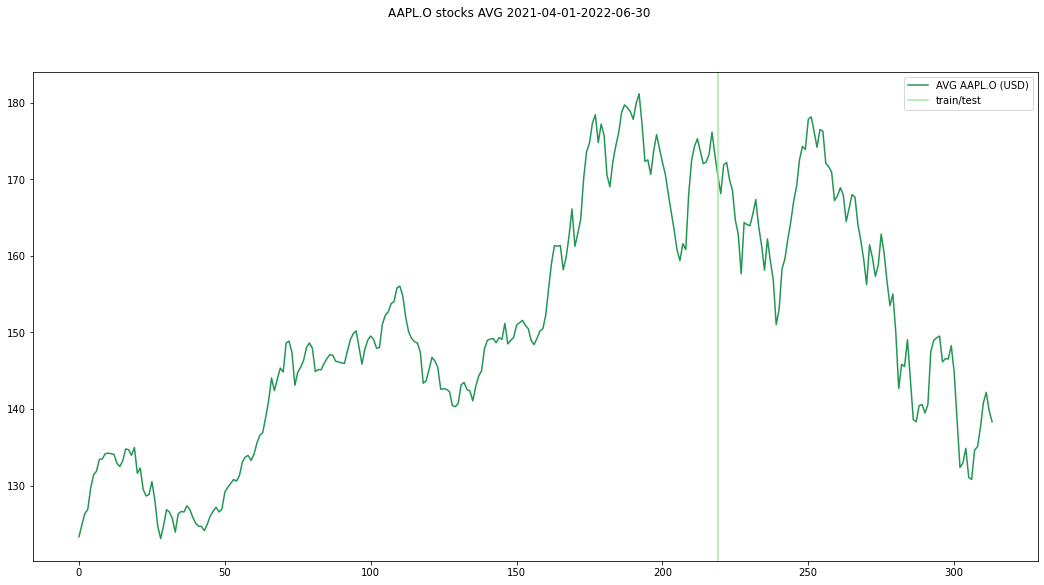

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.991    
Dependent Variable: AVG_TOMORROW     AIC:                819.9010 
Date:               2022-07-11 17:44 BIC:                847.0136 
No. Observations:   219              Log-Likelihood:     -401.95  
Df Model:           7                F-statistic:        3291.    
Df Residuals:       211              Prob (F-statistic): 1.29e-211
R-squared:          0.991            Scale:              2.3872   
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
const        1.6959     1.1537    1.4699   0.1431   -0.5784   3.9702
HIGH         0.0695     0.1818    0.3822   0.7027   -0.2889   0.4279
LOW          0.3605     0.1777    2.0292   0.0437    0.0103   0.7107
OPEN        -0.2663     0.1421   -1.8745   0.0622   -0.5463   0.0137

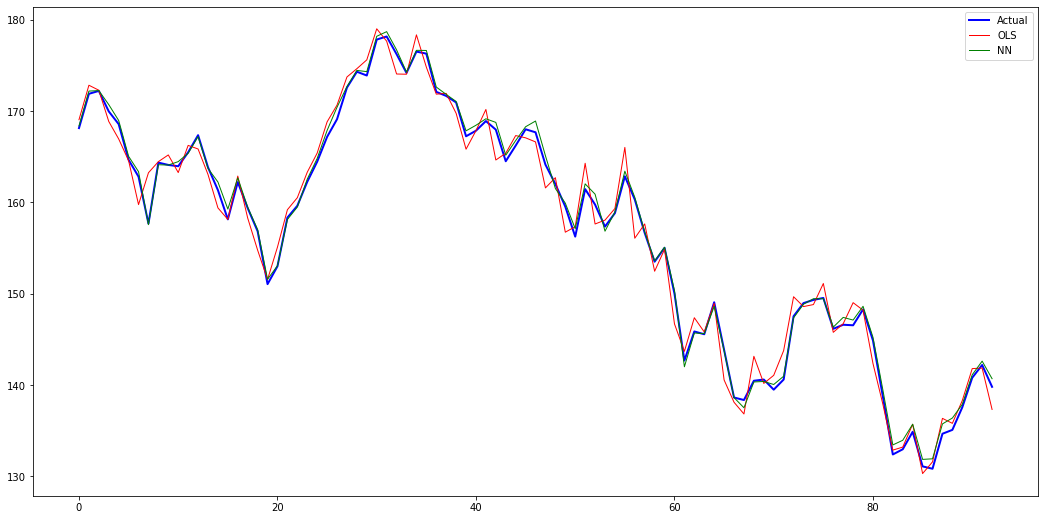

Mean Squared Error of NN model:  0.3078726244338866
Mean Squared Error of OLS:  2.709550415781781


In [9]:
main(ticker = 'AAPL.O')

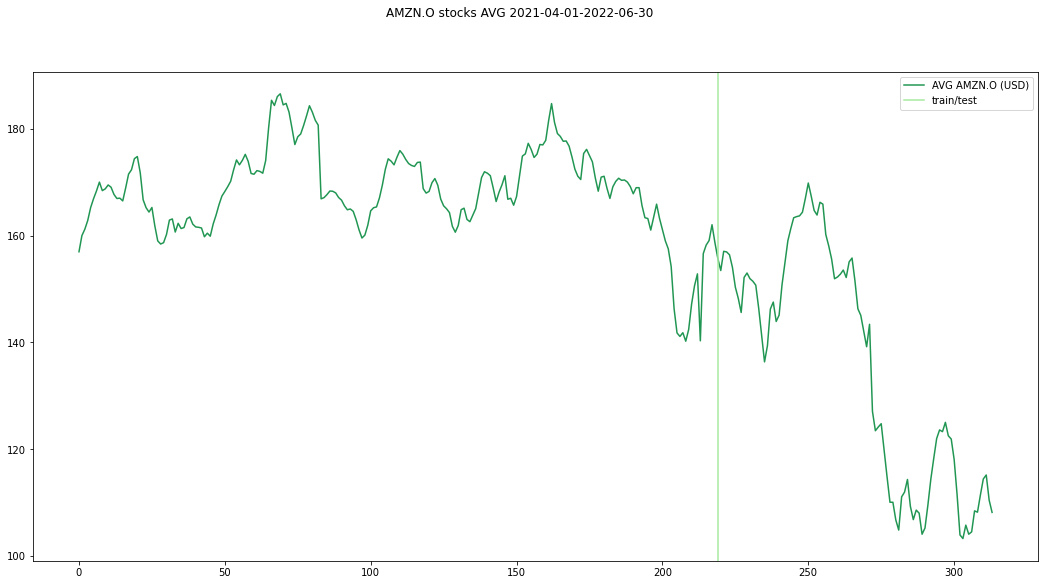

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.932    
Dependent Variable: AVG_TOMORROW     AIC:                975.6470 
Date:               2022-07-11 17:44 BIC:                1002.7596
No. Observations:   219              Log-Likelihood:     -479.82  
Df Model:           7                F-statistic:        429.1    
Df Residuals:       211              Prob (F-statistic): 4.90e-121
R-squared:          0.934            Scale:              4.8612   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const       7.1581     3.2873    2.1775   0.0305    0.6780   13.6382
HIGH        0.2125     0.1973    1.0769   0.2828   -0.1765    0.6014
LOW         0.4856     0.1768    2.7472   0.0065    0.1372    0.8341
OPEN       -0.4611     0.1686   -2.7347   0.0068   -0.7934   -0.1287

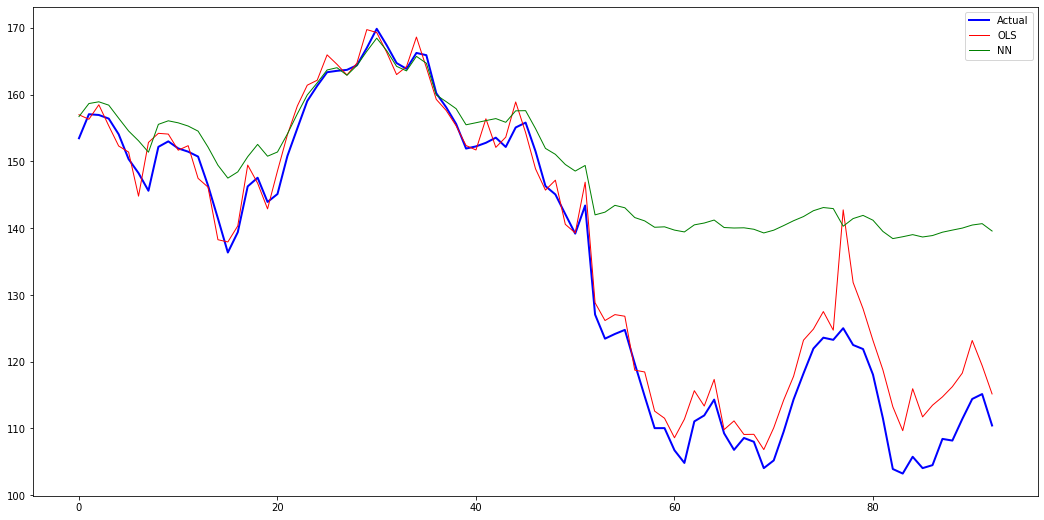

Mean Squared Error of NN model:  354.98378447301786
Mean Squared Error of OLS:  18.039098109551034


In [10]:
main(ticker = 'AMZN.O')

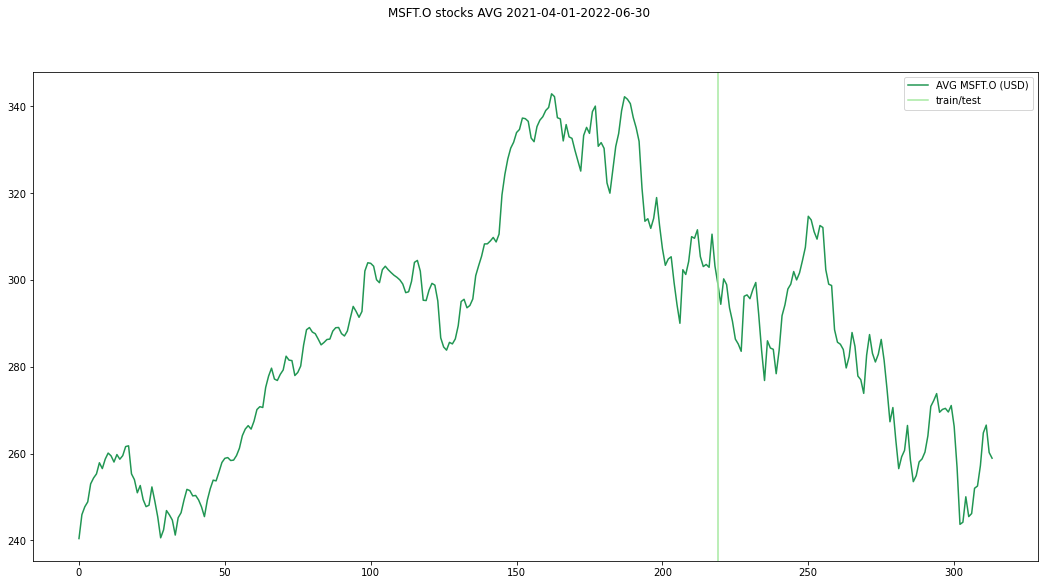

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.991    
Dependent Variable: AVG_TOMORROW     AIC:                1091.2358
Date:               2022-07-11 17:44 BIC:                1118.3484
No. Observations:   219              Log-Likelihood:     -537.62  
Df Model:           7                F-statistic:        3284.    
Df Residuals:       211              Prob (F-statistic): 1.57e-211
R-squared:          0.991            Scale:              8.2407   
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
const        3.0106     2.2313    1.3492   0.1787   -1.3879   7.4091
HIGH         0.1915     0.1724    1.1106   0.2680   -0.1484   0.5313
LOW          0.0376     0.1609    0.2336   0.8155   -0.2795   0.3547
OPEN        -0.0648     0.1288   -0.5034   0.6152   -0.3187   0.1890

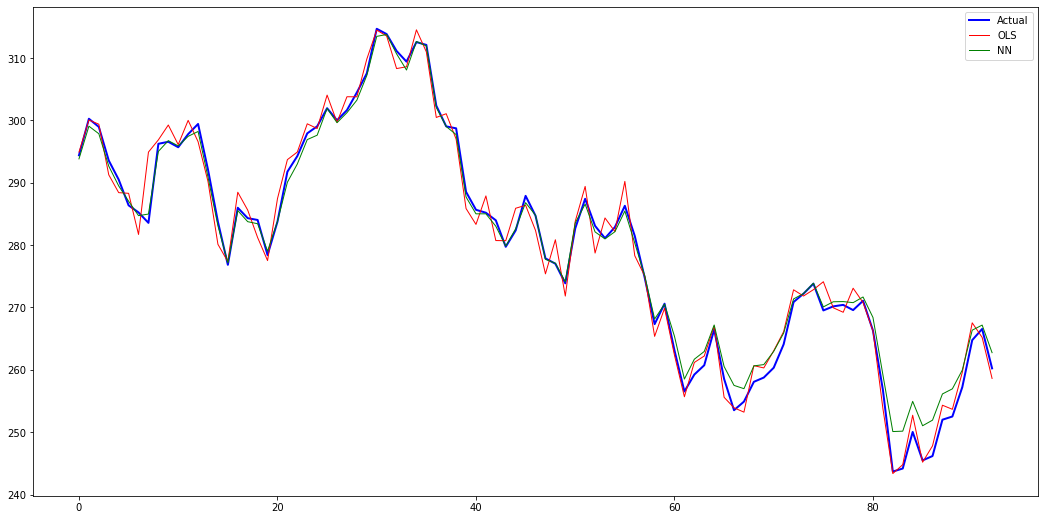

Mean Squared Error of NN model:  3.5941229033255193
Mean Squared Error of OLS:  5.746718169131486


In [11]:
main(ticker = 'MSFT.O')

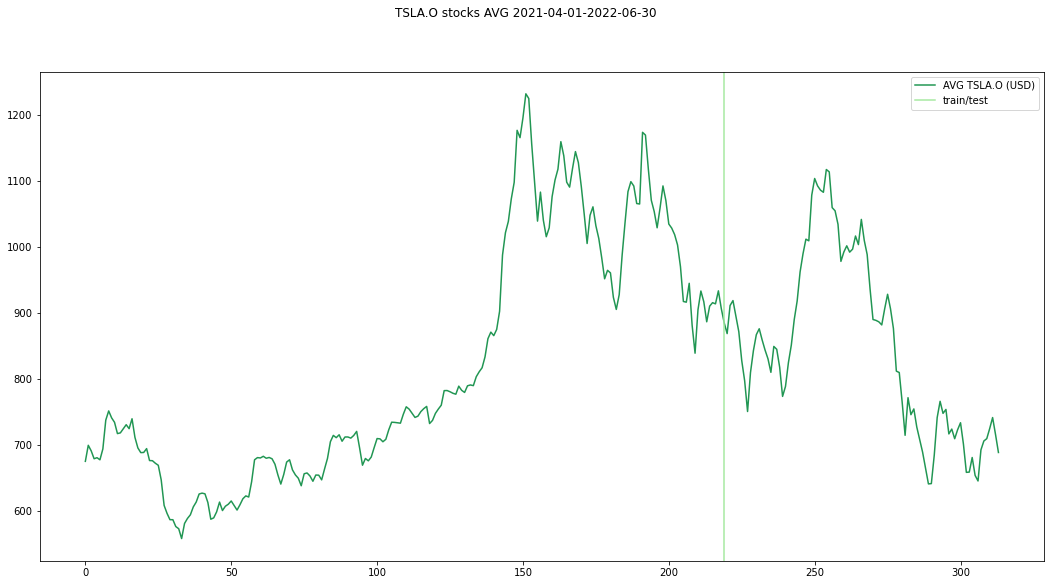

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.988    
Dependent Variable: AVG_TOMORROW     AIC:                1938.2710
Date:               2022-07-11 17:44 BIC:                1965.3836
No. Observations:   219              Log-Likelihood:     -961.14  
Df Model:           7                F-statistic:        2542.    
Df Residuals:       211              Prob (F-statistic): 6.58e-200
R-squared:          0.988            Scale:              394.19   
--------------------------------------------------------------------
           Coef.    Std.Err.      t      P>|t|     [0.025     0.975]
--------------------------------------------------------------------
const      0.6783    10.2520    0.0662   0.9473   -19.5312   20.8877
HIGH      -0.1348     0.1760   -0.7658   0.4446    -0.4819    0.2122
LOW        0.1427     0.1619    0.8812   0.3792    -0.1765    0.4618
OPEN      -0.0057     0.1321   -0.0433   0.9655    -0.2662    0.2547

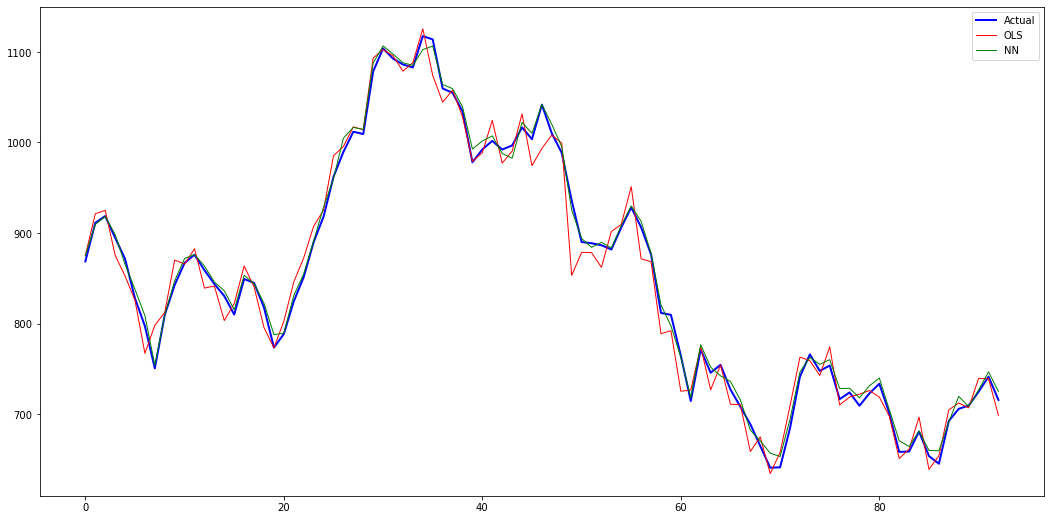

Mean Squared Error of NN model:  53.66423920956459
Mean Squared Error of OLS:  357.66524529296174


In [12]:
main(ticker = 'TSLA.O')

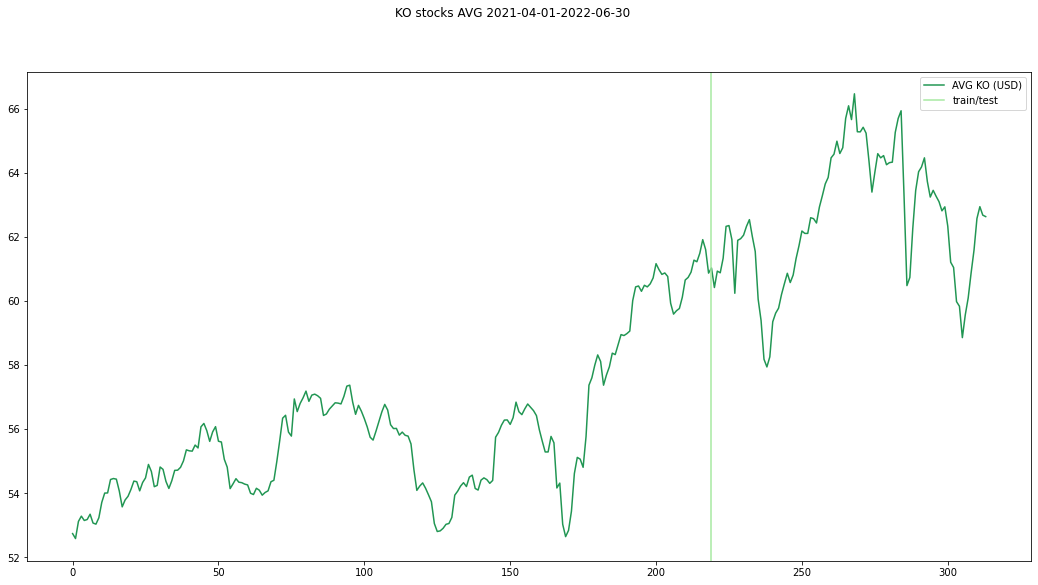

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.979    
Dependent Variable: AVG_TOMORROW     AIC:                145.6368 
Date:               2022-07-11 17:45 BIC:                172.7494 
No. Observations:   219              Log-Likelihood:     -64.818  
Df Model:           7                F-statistic:        1430.    
Df Residuals:       211              Prob (F-statistic): 5.62e-174
R-squared:          0.979            Scale:              0.10984  
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
const        1.1257     0.5780    1.9475   0.0528   -0.0137   2.2652
HIGH        -0.0246     0.1480   -0.1661   0.8682   -0.3162   0.2671
LOW          0.0577     0.1528    0.3774   0.7062   -0.2435   0.3589
OPEN         0.0250     0.1106    0.2262   0.8213   -0.1930   0.2430

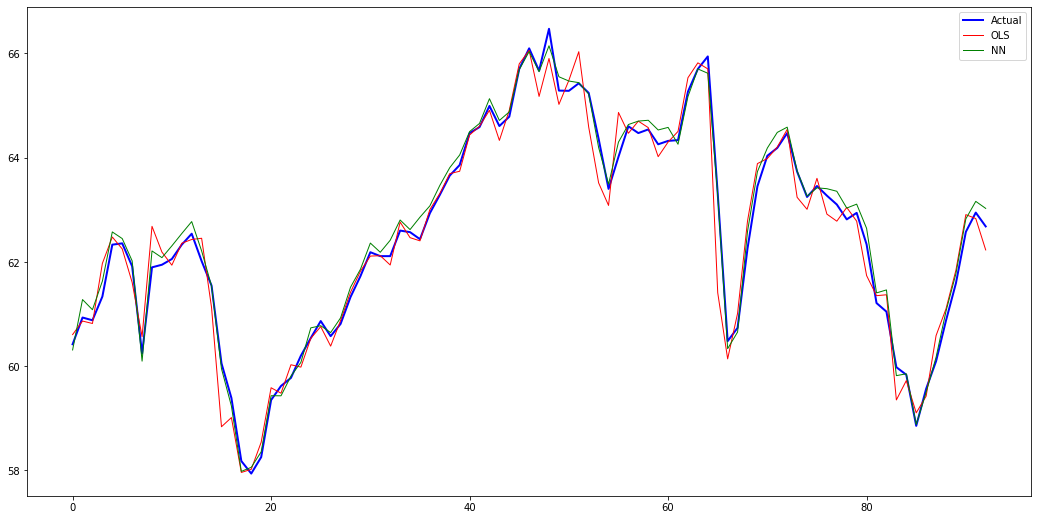

Mean Squared Error of NN model:  0.03518033576646622
Mean Squared Error of OLS:  0.14887357320834885


In [13]:
main(ticker = 'KO')

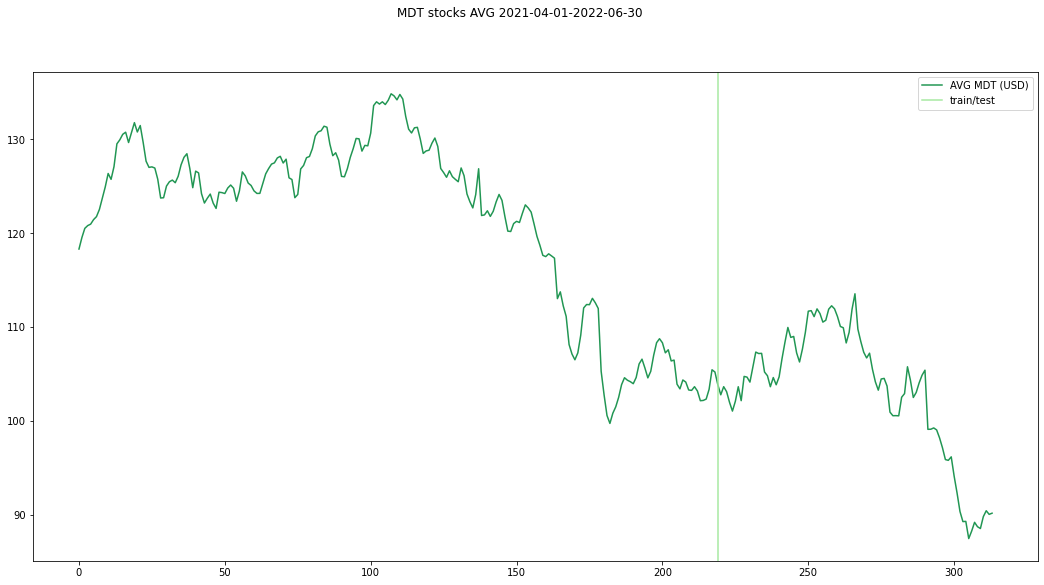

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.988    
Dependent Variable: AVG_TOMORROW     AIC:                653.1308 
Date:               2022-07-11 17:45 BIC:                680.2433 
No. Observations:   219              Log-Likelihood:     -318.57  
Df Model:           7                F-statistic:        2576.    
Df Residuals:       211              Prob (F-statistic): 1.60e-200
R-squared:          0.988            Scale:              1.1147   
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const       1.8628     1.3473    1.3826   0.1682   -0.7931    4.5188
HIGH        0.0915     0.1373    0.6664   0.5059   -0.1791    0.3621
LOW        -0.3642     0.1725   -2.1114   0.0359   -0.7043   -0.0242
OPEN        0.0964     0.1154    0.8353   0.4045   -0.1311    0.3239

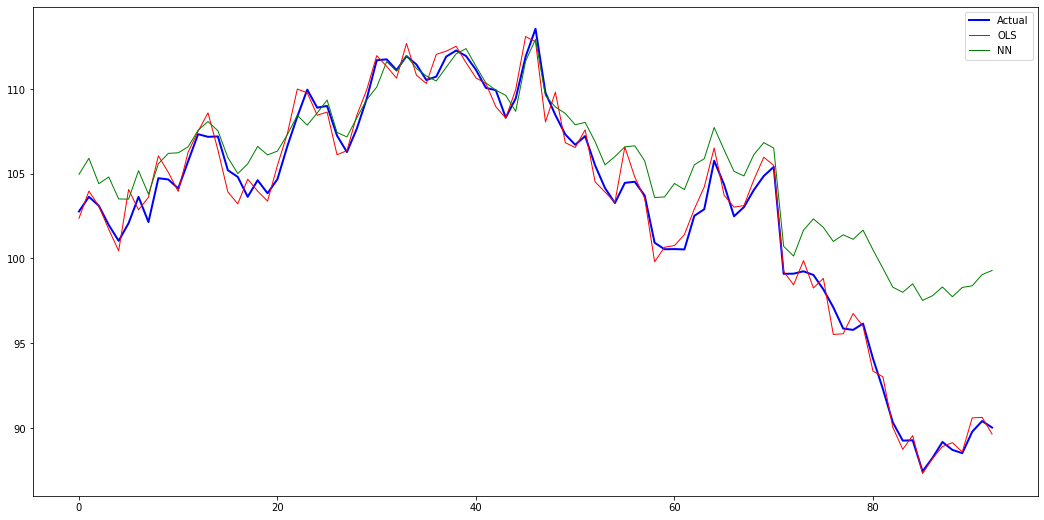

Mean Squared Error of NN model:  14.32723729168111
Mean Squared Error of OLS:  0.6154328313213744


In [14]:
main(ticker = 'MDT')

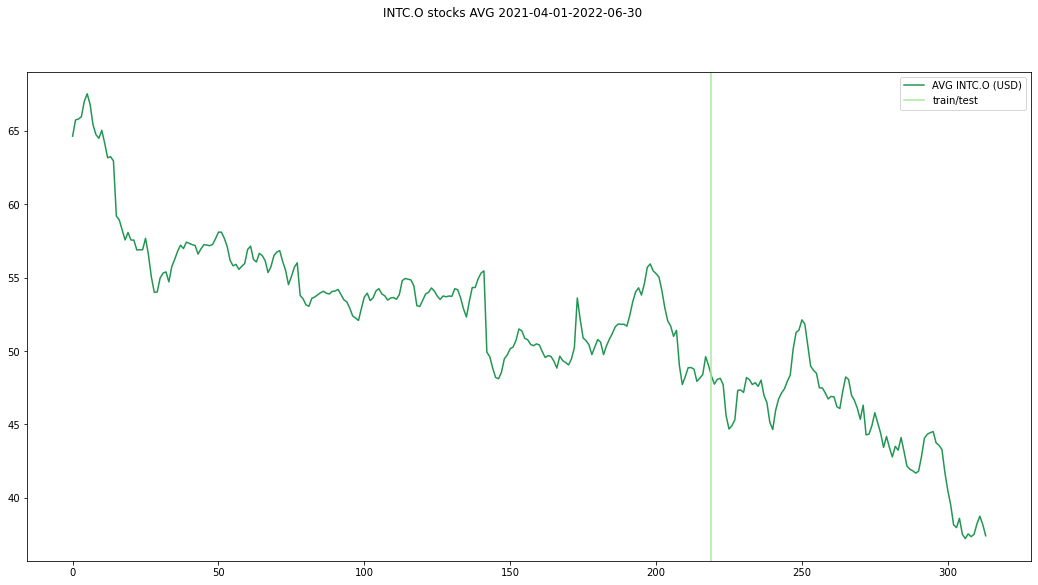

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.968    
Dependent Variable: AVG_TOMORROW     AIC:                475.7126 
Date:               2022-07-11 17:45 BIC:                502.8251 
No. Observations:   219              Log-Likelihood:     -229.86  
Df Model:           7                F-statistic:        951.7    
Df Residuals:       211              Prob (F-statistic): 8.25e-156
R-squared:          0.969            Scale:              0.49583  
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const       2.2691     0.7483    3.0324   0.0027    0.7941    3.7442
HIGH        0.0143     0.1918    0.0748   0.9405   -0.3638    0.3925
LOW        -0.1066     0.2020   -0.5277   0.5983   -0.5047    0.2916
OPEN        0.1743     0.1504    1.1590   0.2477   -0.1222    0.4709

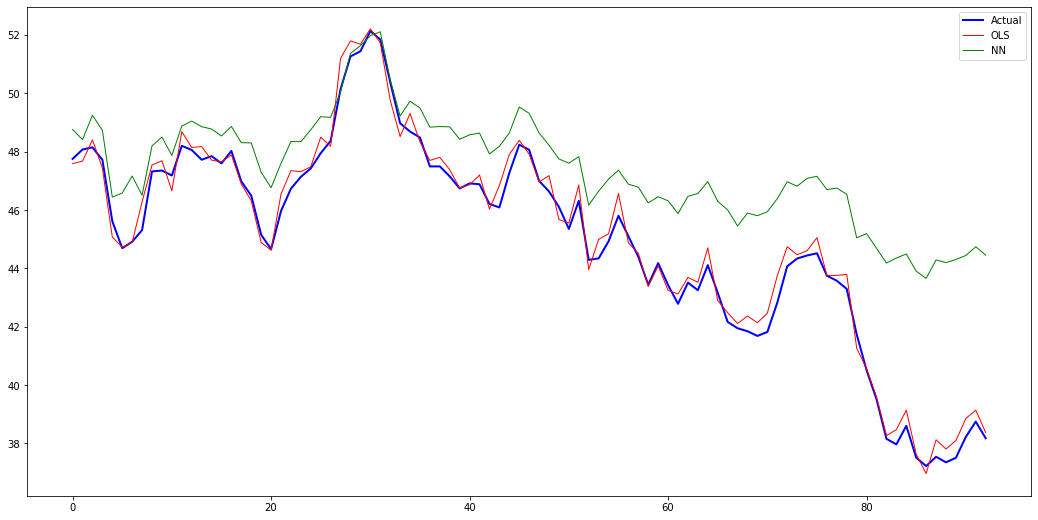

Mean Squared Error of NN model:  9.014551307937955
Mean Squared Error of OLS:  0.16681711345034678


In [15]:
main(ticker = 'INTC.O')

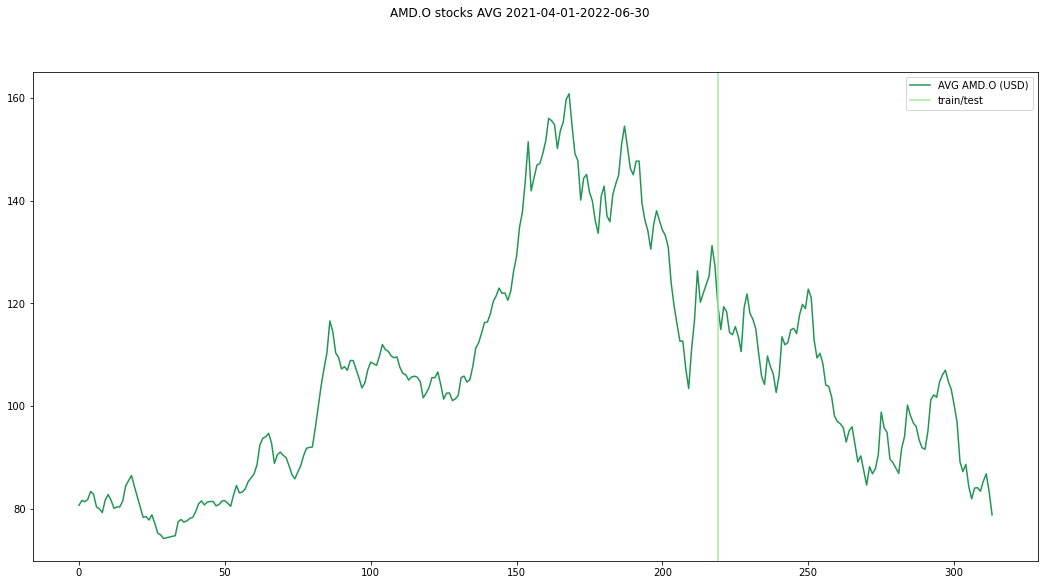

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.993    
Dependent Variable: AVG_TOMORROW     AIC:                956.7436 
Date:               2022-07-11 17:45 BIC:                983.8562 
No. Observations:   219              Log-Likelihood:     -470.37  
Df Model:           7                F-statistic:        4139.    
Df Residuals:       211              Prob (F-statistic): 4.85e-222
R-squared:          0.993            Scale:              4.4592   
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
const       -0.4790     0.8195   -0.5845   0.5595   -2.0945   1.1365
HIGH        -0.2950     0.1510   -1.9534   0.0521   -0.5927   0.0027
LOW          0.2781     0.1511    1.8396   0.0672   -0.0199   0.5760
OPEN        -0.0742     0.1113   -0.6668   0.5057   -0.2937   0.1452

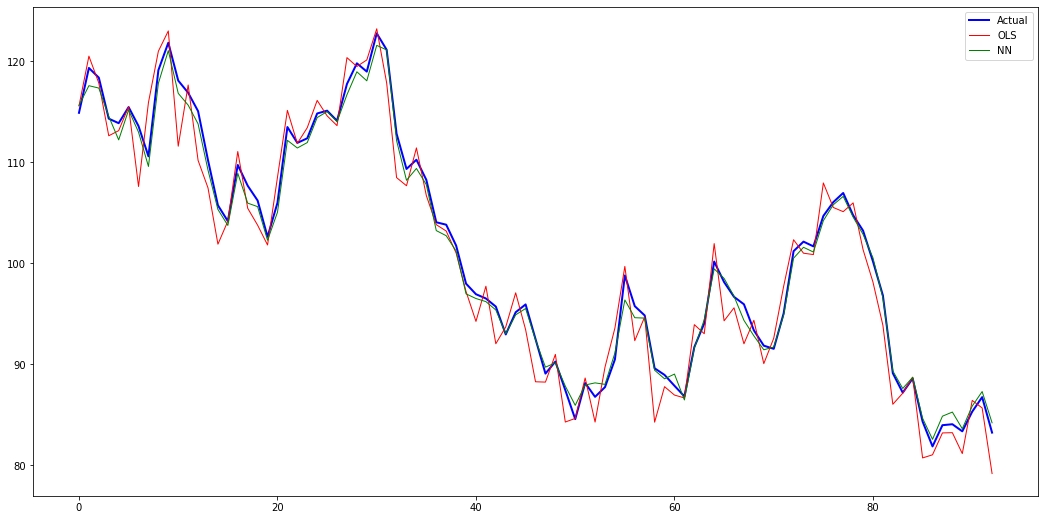

Mean Squared Error of NN model:  0.6372774357276006
Mean Squared Error of OLS:  5.339673521376355


In [16]:
main(ticker = 'AMD.O')

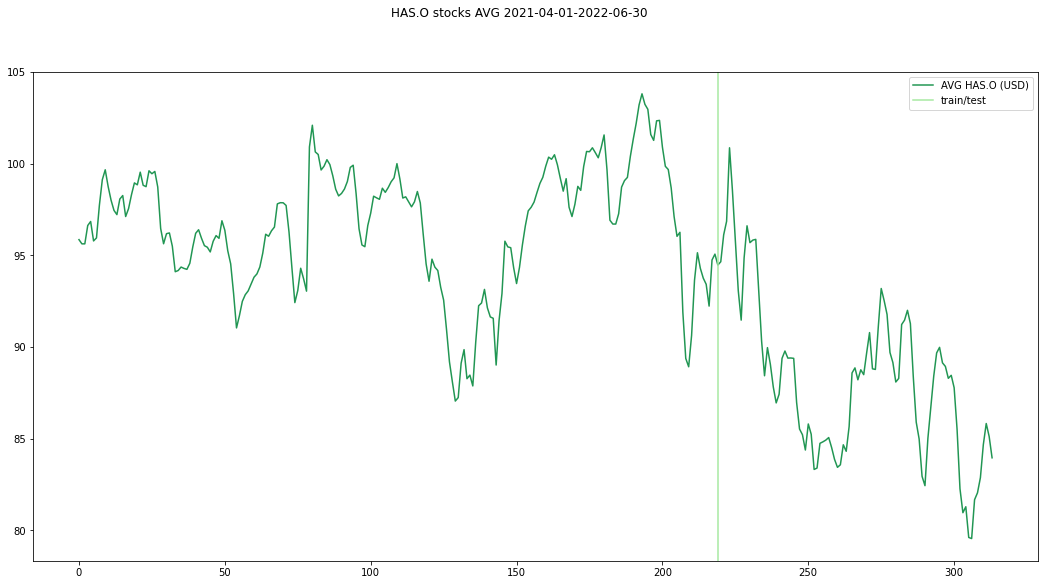

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.923    
Dependent Variable: AVG_TOMORROW     AIC:                603.2424 
Date:               2022-07-11 17:45 BIC:                630.3550 
No. Observations:   219              Log-Likelihood:     -293.62  
Df Model:           7                F-statistic:        371.9    
Df Residuals:       211              Prob (F-statistic): 5.86e-115
R-squared:          0.925            Scale:              0.88764  
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const       6.8315     1.9166    3.5645   0.0005    3.0535   10.6096
HIGH       -0.0293     0.1301   -0.2253   0.8220   -0.2858    0.2272
LOW         0.2150     0.1386    1.5519   0.1222   -0.0581    0.4882
OPEN       -0.1111     0.1083   -1.0255   0.3063   -0.3247    0.1025

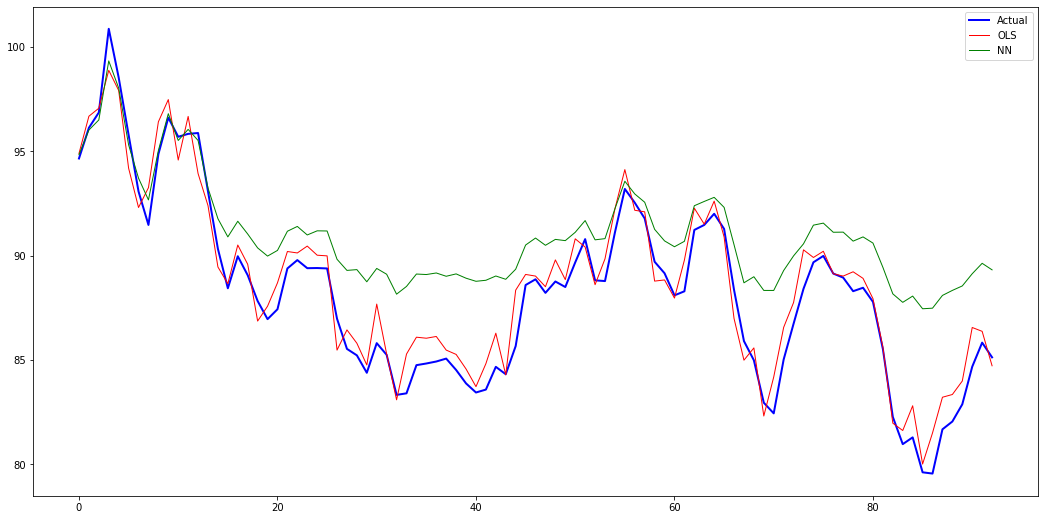

Mean Squared Error of NN model:  11.46175095076568
Mean Squared Error of OLS:  1.0464642363408918


In [17]:
main(ticker = 'HAS.O')

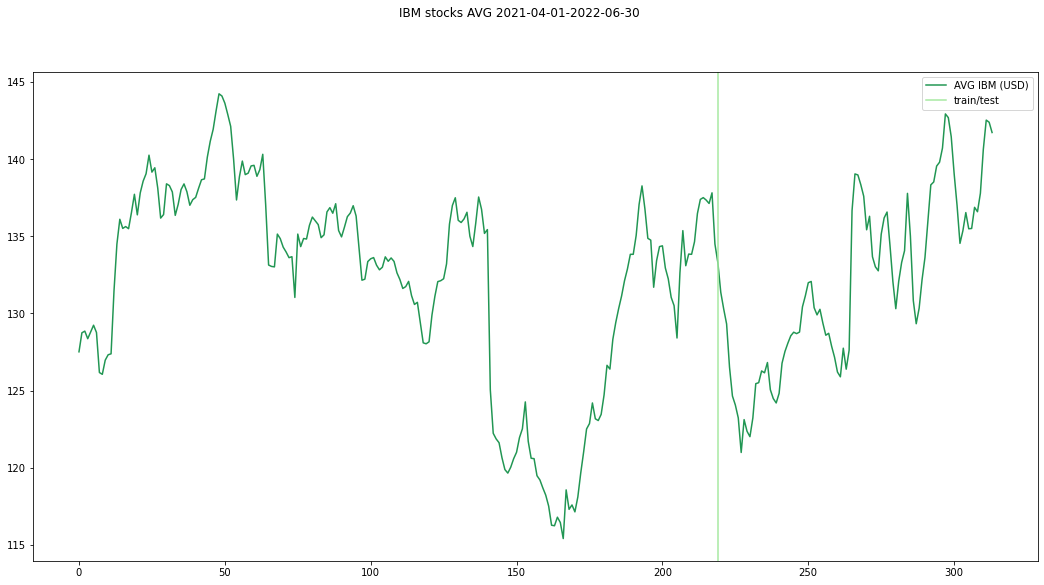

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.964    
Dependent Variable: AVG_TOMORROW     AIC:                730.6087 
Date:               2022-07-11 17:45 BIC:                757.7213 
No. Observations:   219              Log-Likelihood:     -357.30  
Df Model:           7                F-statistic:        841.5    
Df Residuals:       211              Prob (F-statistic): 2.31e-150
R-squared:          0.965            Scale:              1.5879   
--------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
--------------------------------------------------------------------
const        4.0754     1.8123    2.2487   0.0256    0.5028   7.6480
HIGH        -0.1246     0.1595   -0.7815   0.4354   -0.4391   0.1898
LOW         -0.1064     0.1742   -0.6108   0.5420   -0.4499   0.2370
OPEN         0.1086     0.1267    0.8577   0.3921   -0.1411   0.3584

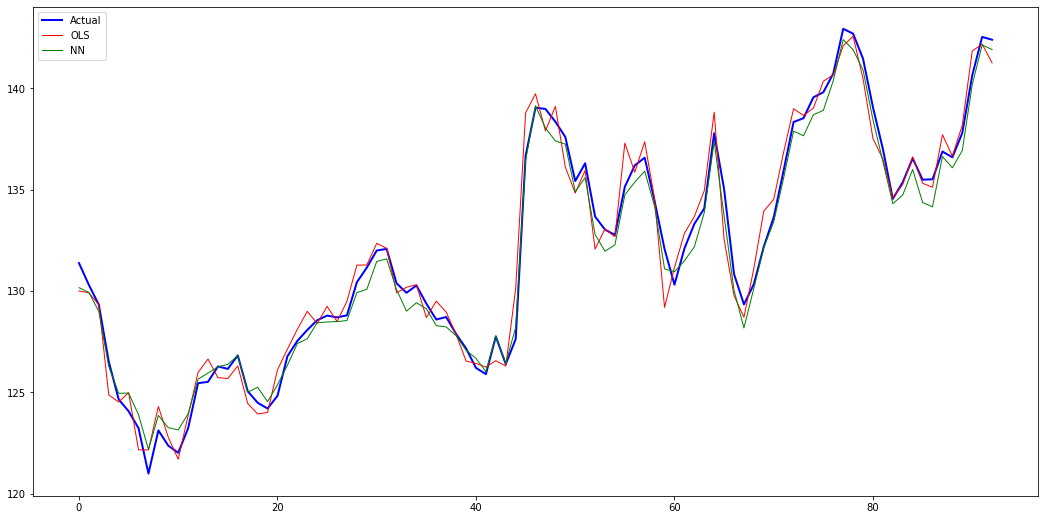

Mean Squared Error of NN model:  0.405187505919918
Mean Squared Error of OLS:  0.846706029230757


In [18]:
main(ticker='IBM')

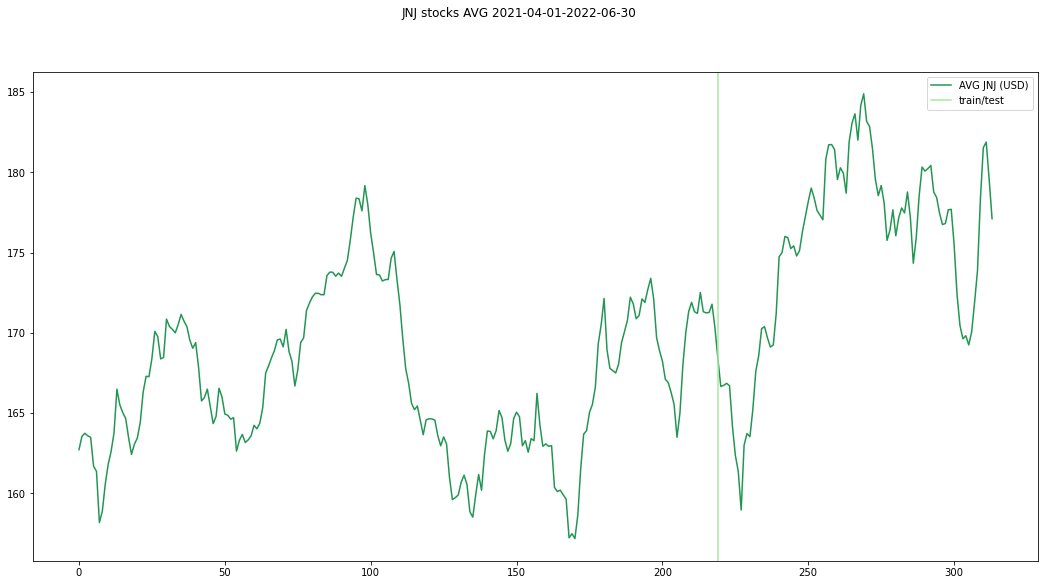

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.960    
Dependent Variable: AVG_TOMORROW     AIC:                603.9600 
Date:               2022-07-11 17:45 BIC:                631.0726 
No. Observations:   219              Log-Likelihood:     -293.98  
Df Model:           7                F-statistic:        751.1    
Df Residuals:       211              Prob (F-statistic): 2.40e-145
R-squared:          0.961            Scale:              0.89055  
--------------------------------------------------------------------
            Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const       5.4194     2.5201    2.1505   0.0327    0.4517   10.3872
HIGH        0.0771     0.1321    0.5835   0.5602   -0.1833    0.3375
LOW        -0.1795     0.1267   -1.4167   0.1581   -0.4294    0.0703
OPEN        0.0621     0.0919    0.6757   0.5000   -0.1191    0.2433

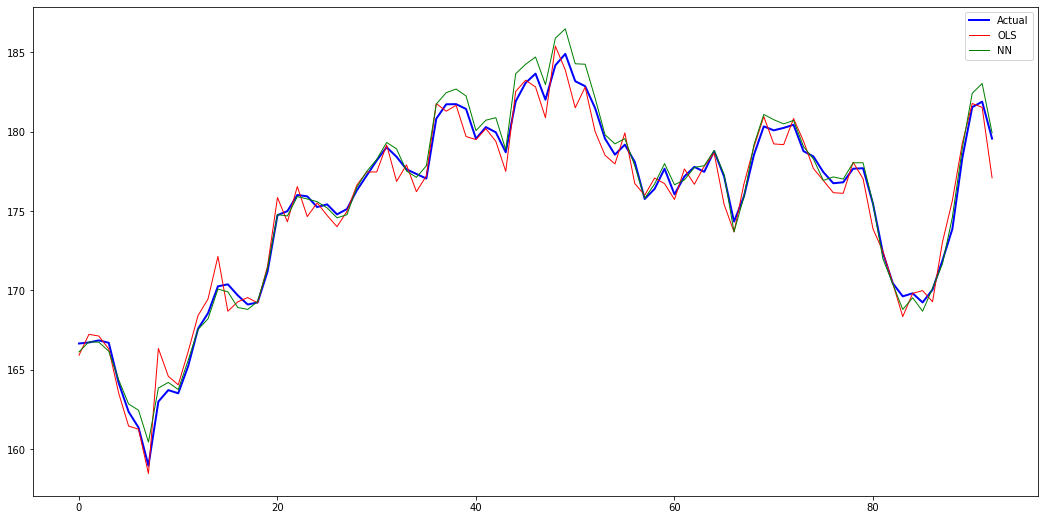

Mean Squared Error of NN model:  0.39148453583006615
Mean Squared Error of OLS:  0.8841508974201747


In [19]:
main(ticker='JNJ')